In [1]:
#testing reaction network code
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from diffrax import diffeqsolve, ODETerm, Tsit5, SaveAt, Kvaerno3, Kvaerno5, PIDController
import optax  
import pickle as pkl
#from reaction_nets import rxn_net
from functools import partial
import random
#from modified_reaction_nets import random_rxn_net
from reaction_nets import random_rxn_net
from rxn_nets_old import rxn_net
import turning_points
from pybaselines import Baseline
import scipy
import scipy.signal
from scipy.signal import savgol_filter
import turning_points_memory_efficient
from analyze_turning_points import load_turning_points_from_text, load_profiles_from_text, profiles_to_turning_points
import turning_points_inputs

# Testing turning point function.

Fix initial conditions for the network.

In [5]:
n=6
m=n*(n-1)/2
seed=1
initial_conditions=jnp.log(jnp.array([1/6, 1/6, 1/6, 1/6, 1/6, 1/6]))#jnp.log(jnp.array([1/3, 1/3, 1/3]))#
all_features=jnp.linspace(-20, 20, 50) #jnp.linspace(-40, 40, 100)
t_points=jnp.linspace(0, 20, 200)
solver= Kvaerno5()
stepsize_controller=PIDController(
    rtol=1e-6,     
    atol=1e-9,   
    dtmin=1e-11,   
    dtmax=1e-1     
)
dt=0.1
max_steps=10000000
second_order_edge_idxs=None#jnp.array([[0, 1]]) #fixing the location of the second order edge 
n_second_order=1
n_inputs=1

In [6]:
rxn=random_rxn_net(n, m, seed, n_second_order, n_inputs, test=False, A=None, second_order_edge_idxs=second_order_edge_idxs, F_a_idxs=None)

In [4]:
rxn.A

Array([[0, 1, 1, 1, 1, 1],
       [1, 0, 1, 1, 1, 1],
       [1, 1, 0, 1, 1, 1],
       [1, 1, 1, 0, 1, 1],
       [1, 1, 1, 1, 0, 1],
       [1, 1, 1, 1, 1, 0]], dtype=int64)

In [7]:
print(rxn.F_a_idxs)

[[2 1]]


In [8]:
rxn.second_order_edges

Array([[2, 0]], dtype=int64)

In [9]:
rxn.second_order_edge_prods

Array([[0, 2]], dtype=int64)

In [10]:
rxn.second_order_edge_reactants

Array([[2, 3]], dtype=int64)

Generate 10000 random parameter sets, sampled from Unif[-10, 10].

In [8]:
params_all=[]
key = jax.random.PRNGKey(0)
subkeys = jax.random.split(key, 10000)
for subkey in subkeys:
    key1, key2, key3=jax.random.split(subkey, 3)
    B=jax.random.uniform(key1, shape=(n**2 - n), minval=-5, maxval=5) 
    F=jax.random.uniform(key2, shape=(n**2-n)//2, minval=-5, maxval=5) 
    E=jax.random.uniform(key3, shape=n, minval=-5, maxval=5)
    params_all.append([E, B, F])


In [9]:
params_file=f'data/turning_points/params_all_N0'

f=open(params_file, 'wb')
pkl.dump(params_all, f)
f.close()

In [11]:
params_file=f'data/turning_points/params_all_N0'#f'data/turning_points/params_all_N3_S0'

f=open(params_file, 'rb')
params_all=pkl.load(f)
f.close()

In [40]:
params_all[0]

[Array([-0.95767404, -4.42344102, -0.81178903,  0.23851545,  2.50671983,
         3.69578794], dtype=float64),
 Array([-3.40969749,  3.22196664,  4.36304053,  3.5653223 ,  2.12491472,
         4.63707705, -3.22645281,  0.0797938 , -4.35707727, -1.19119925,
         2.6128398 ,  0.98987994, -4.46695801, -3.54018735, -4.65952519,
         4.45343421, -1.50677345, -3.66812326, -2.08718232, -4.07374758,
         3.95711248, -0.34161081,  0.80490757,  1.79278426,  2.20678375,
         0.78646823, -0.08974455,  4.52446826,  3.83498106,  0.81352021],      dtype=float64),
 Array([ 1.71192987,  2.57670611, -4.35635206,  4.15343702,  0.10532753,
         2.59833024,  0.28830426, -2.4884716 , -3.0044889 ,  0.82084354,
        -4.54985429,  2.21907592,  3.32807009, -0.62086941,  1.23246458],      dtype=float64)]

In [12]:
sol_check=turning_points.profile(rxn, params_all[3], initial_conditions, all_features, solver, stepsize_controller, t_points, dt, max_steps)

For testing three node network.

In [14]:
'''
params_file=f'data/turning_points/params_all_N3_S0'

f=open(params_file, 'rb')
params_all=pkl.load(f)
f.close()
'''
n=3
m=n*(n-1)/2
second_order_edge_idxs=jnp.array([[0, 1]]) #fixing the location of the second order edge 
n_second_order=1
n_inputs=1
test=True
A=np.array([[0, 1, 1], [1, 0, 1], [1, 1, 0]]) #adjacency matrix
second_order_edge_idxs=np.array([[0, 1]])
F_a_idxs=np.array([[1, 2]])
E=np.array([0, 0, 0])
B=-1*jnp.log(np.array([1, 1, 10, 0.05, 0.1, 4]))
F=np.array([0, 0, 0])
test_params=(E, B, F)
seed=0
all_features=jnp.linspace(-20, 20, 50) #jnp.linspace(-40, 40, 100)
t_points=jnp.linspace(0, 20, 200)
solver= Kvaerno5()
stepsize_controller=PIDController(
    rtol=1e-6,     
    atol=1e-9,   
    dtmin=1e-11,   
    dtmax=1e-1     
)
dt=0.1
max_steps=10000000
rxn_test=random_rxn_net(n, m, seed, n_second_order, n_inputs, test, A, second_order_edge_idxs, F_a_idxs)

print(rxn_test.rxn_net_dynamics(1, jnp.log(jnp.array([0.2, 0.5, 0.3])), (E, B, F, 1,)))


[ 0.9        -2.176661    3.02776833]


In [42]:
sol_check=turning_points.profile(rxn_test, test_params, jnp.log(jnp.array([0.2, 0.5, 0.3])), all_features, solver, stepsize_controller, t_points, dt, max_steps)

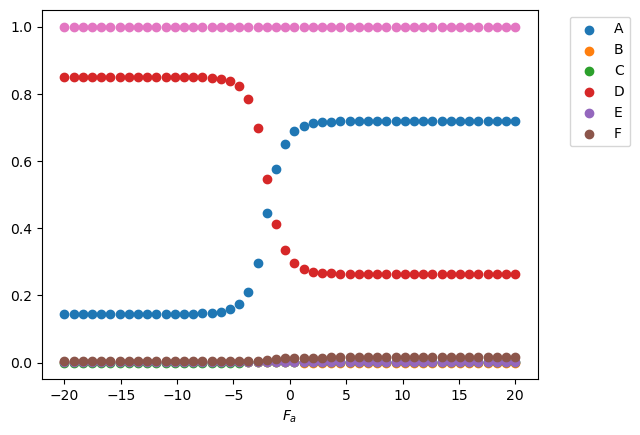

In [49]:
#baseline_fitter=Baseline(x_data=all_features)
species=['A', 'B', 'C', 'D', 'E', 'F']
for i in range(6):
    #plt.plot(all_features, baseline_fitter.arpls(sol_check.T[i], lam=0.5)[0])
    plt.scatter(all_features, sol_check.T[i], label=species[i])
    
plt.scatter(all_features, jnp.sum(sol_check, 1))
plt.xlabel(r'$F_a$')
plt.legend(bbox_to_anchor=[1.05, 1.0], loc='upper left')

In [35]:
def count_turning_points_unfiltered(data, all_features, window_length=11, polyorder=2):
    if len(data) < window_length:
        window_length = max(min(len(data) - 2, 7), 3)
        window_length = window_length if window_length % 2 == 1 else window_length - 1
        polyorder = min(polyorder, window_length - 2)
    
    # Apply Savitzky-Golay filter to smooth the data
    smoothed_data = savgol_filter(data, window_length, polyorder)
    peaks, props = scipy.signal.find_peaks(data)
    troughs,props = scipy.signal.find_peaks(-data)

    # Get prominence details
    prominences, left_bases, right_bases = scipy.signal.peak_prominences(smoothed_data, peaks)
    print(f"Peak prominences: {prominences}")
    prominences, left_bases, right_bases = scipy.signal.peak_prominences(-smoothed_data, troughs)
    print(f"Peak prominences: {prominences}")
    
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    #plt.plot(all_features, data, 'b-', alpha=0.7, label='Original data')
    plt.plot(all_features, smoothed_data, 'r-', linewidth=2, label='ARPLS baseline')
    plt.scatter(all_features[peaks], smoothed_data[peaks], color='red', s=100, zorder=5, label=f'{len(peaks)} peaks')
    plt.scatter(all_features[troughs], smoothed_data[troughs], color='green', s=100, zorder=5, label=f'{len(troughs)} troughs')
    plt.legend()
    #plt.grid(True, alpha=0.3)
    #plt.title('Original data vs ARPLS baseline')
    

In [2]:
def count_turning_points_w_plot(data,all_features, window_length=11, polyorder=2, min_width=5):
    
    if len(data) < window_length:
        window_length = max(min(len(data) - 2, 7), 3)
    window_length = window_length if window_length % 2 == 1 else window_length - 1
    polyorder = min(polyorder, window_length - 2)
    # Apply Savitzky-Golay filter to smooth the data
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    #plt.plot(all_features, data, 'b-', alpha=0.7, label='Original data')
    plt.scatter(all_features, data, color='black', label='unsmoothed')

    data = savgol_filter(data, window_length, polyorder)
    plt.plot(all_features, data, 'r-', linewidth=2, label='smoothed')
    min_prominence=0.1*np.max(data)

    # Find peaks based on prominence criterion
    prominence_peaks, _ = scipy.signal.find_peaks(data, prominence=min_prominence)
    prominence_troughs, _ = scipy.signal.find_peaks(-data, prominence=min_prominence)
    
    # Find peaks based on width criterion
    width_peaks, _ = scipy.signal.find_peaks(data, width=min_width)
    width_troughs, _ = scipy.signal.find_peaks(-data, width=min_width)

    # Combine unique peaks and troughs from both criteria
    all_peaks = np.unique(np.concatenate((prominence_peaks, width_peaks)))
    all_troughs = np.unique(np.concatenate((prominence_troughs, width_troughs)))
    
    bad_points = ~np.isfinite(data)
    
    # Expand the mask to include neighbors of bad points
    bad_points_expanded = bad_points.copy()
    
    # Mark neighbors of bad points as bad too
    for i in range(len(bad_points)):
        if bad_points[i]:
            # Mark left neighbor as bad
            if i > 0:
                bad_points_expanded[i-1] = True
            # Mark right neighbor as bad  
            if i < len(bad_points) - 1:
                bad_points_expanded[i+1] = True
    
    # FILTER PEAKS AND TROUGHS
    # Remove peaks that are at bad points or next to bad points
    valid_peaks = all_peaks[~bad_points_expanded[all_peaks]]
    valid_troughs = all_troughs[~bad_points_expanded[all_troughs]]

    print(valid_peaks, data[valid_peaks])
    print(valid_troughs, data[valid_troughs])

    finite_peaks = np.isfinite(data[valid_peaks])  # boolean array, True for finite values
    count_finite_peaks = np.sum(finite_peaks)

    # Count finite values in all_troughs
    finite_troughs = np.isfinite(data[valid_troughs])
    count_finite_troughs = np.sum(finite_troughs)

    peaks_to_plot=valid_peaks[np.where(finite_peaks)]
    troughs_to_plot=valid_troughs[np.where(finite_troughs)]
    
    print(peaks_to_plot)
    print(troughs_to_plot)
    print('widths')
    print(scipy.signal.peak_widths(data, peaks_to_plot)[0])
    print(scipy.signal.peak_widths(-data, troughs_to_plot)[0])
    print('prominences')
    print(scipy.signal.peak_prominences(data, peaks_to_plot)[0])
    print(scipy.signal.peak_prominences(-data, troughs_to_plot)[0])

    if finite_peaks.shape[0] > 0:
        print('num finite peaks: ', finite_peaks.shape[0])
        plt.scatter(all_features[peaks_to_plot], data[peaks_to_plot], color='red', s=100, zorder=5, label=f'{len(all_peaks)} peaks')
    if finite_troughs.shape[0] > 0:
        print('num finite troughs', finite_troughs.shape[0])
        plt.scatter(all_features[troughs_to_plot], data[troughs_to_plot], color='green', s=100, zorder=5, label=f'{len(all_troughs)} troughs')
        print('plotted at: ', all_features[troughs_to_plot], data[troughs_to_plot])
    #for j in all_peaks:
    #    plt.axvline(all_features[j])
    #for j in all_troughs:
    #    plt.axvline(all_features[j])
    #plt.legend()

    #    Total finite values in both arrays
    total_finite = count_finite_peaks + count_finite_troughs
    print('total finite: ', total_finite)

    return total_finite

Peak prominences: [0.]
Peak prominences: []


/var/folders/lf/7gzndb3s11g08rld41m9cfdc0000gn/T/ipykernel_18106/1102412064.py:13: PeakPropertyWarning: some peaks have a prominence of 0
  prominences, left_bases, right_bases = scipy.signal.peak_prominences(smoothed_data, peaks)


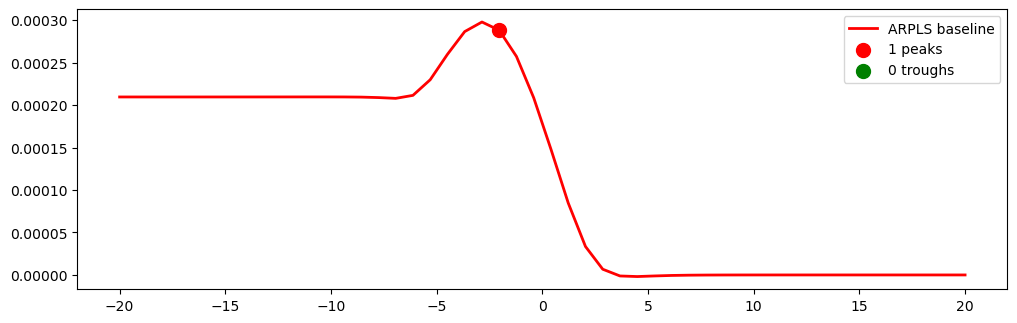

In [58]:
count_turning_points_unfiltered(sol_check.T[1], all_features)

[]
[11 29 46]
[ 2 18 41]


0

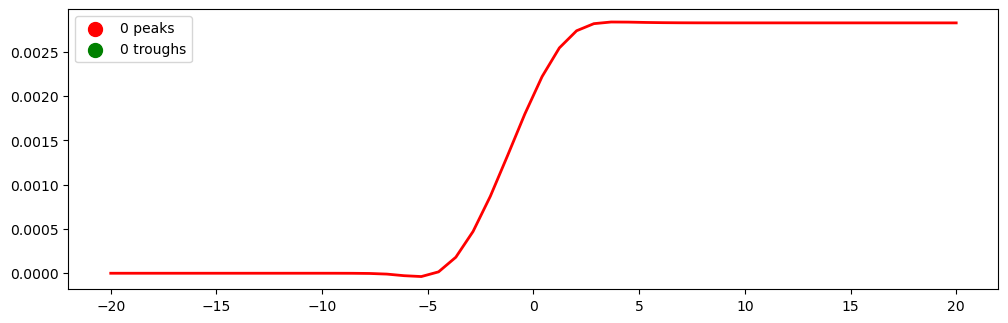

In [ ]:
count_turning_points_w_plot(sol_check.T[2], all_features)

In [32]:
def test_prominence_thresholds(n_tests=5):
    """
    Tests different prominence thresholds and recommends a suitable value.
    Data is restricted to 0 to 1 range for both x and y axes.
    
    Args:
        n_tests: Number of test signals to generate
    
    Returns:
        recommended_prominence: Recommended prominence threshold value
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import find_peaks, peak_prominences
    
    # Create figure for visualization
    fig, axes = plt.subplots(n_tests, 3, figsize=(18, 4*n_tests))
    
    # Test on different synthetic signals - smaller prominence values for 0-1 range
    prominence_values = np.logspace(-4, -1, 20)  # Test from 0.0001 to 0.1
    results = []
    
    for test_idx in range(n_tests):
        # Generate x values in range [0, 1]
        x = np.linspace(0, 1, 1000)
        
        # Generate different test signals, all strictly in [0, 1] range
        if test_idx == 0:
            # Sine wave (0.5 ± 0.4 to keep room for noise)
            signal = 0.5 + 0.4 * np.sin(14 * np.pi * x)  # 7 peaks
            true_peaks = 7
            noise_level = 0.02
            signal_name = "Sine wave"
        elif test_idx == 1:
            # Double sine (carefully scaled to stay in range)
            signal = 0.5 + 0.2 * np.sin(12 * np.pi * x) + 0.2 * np.sin(30 * np.pi * x)
            # Double check range
            signal = np.clip(signal, 0, 1)
            true_peaks = 15
            noise_level = 0.03
            signal_name = "Double sine"
        elif test_idx == 2:
            # Gaussian peaks
            signal = (0.8 * np.exp(-((x-0.2)/0.05)**2) + 
                     0.6 * np.exp(-((x-0.5)/0.05)**2) + 
                     0.9 * np.exp(-((x-0.8)/0.05)**2))
            # Normalize to exactly [0, 1]
            signal = signal / np.max(signal)
            true_peaks = 3
            noise_level = 0.01
            signal_name = "Gaussian peaks"
        elif test_idx == 3:
            # Damped oscillation
            signal = np.exp(-5 * (x-0.5)**2) * np.cos(30 * np.pi * x)
            # Normalize to exactly [0, 1]
            signal = (signal - np.min(signal)) / (np.max(signal) - np.min(signal))
            true_peaks = 5
            noise_level = 0.01
            signal_name = "Damped oscillation"
        else:
            # Polynomial with local maxima
            signal = 10 * (x * (1-x))**2 * np.sin(12 * np.pi * x)
            # Normalize to exactly [0, 1]
            signal = (signal - np.min(signal)) / (np.max(signal) - np.min(signal))
            true_peaks = 6
            noise_level = 0.02
            signal_name = "Oscillating polynomial"
        
        # Extra safety check - ensure signal is in [0, 1] range
        signal = np.clip(signal, 0, 1)
        
        # Add noise with buffer to avoid exceeding range
        # Scale noise to be smaller near 0 and 1 to prevent clipping
        buffer = np.minimum(signal, 1-signal)  # How far from 0 or 1
        variable_noise = noise_level * np.minimum(buffer*3, 1)  # Smaller noise near boundaries
        noisy_signal = signal + np.random.normal(0, variable_noise)
        
        # Ensure noisy signal stays in [0, 1]
        noisy_signal = np.clip(noisy_signal, 0, 1)
        
        # Test different prominence values
        peak_counts = []
        best_match_idx = 0
        best_match_diff = float('inf')
        worst_match_diff = 0
        window_length=11
        polyorder=2
        if len(noisy_signal) < window_length:
            window_length = max(min(len(noisy_signal) - 2, 7), 3)
            window_length = window_length if window_length % 2 == 1 else window_length - 1
            polyorder = min(polyorder, window_length - 2)
    
        # Apply Savitzky-Golay filter to smooth the data
        noisy_signal = savgol_filter(noisy_signal, window_length, polyorder)
        
        for i, prom in enumerate(prominence_values):
            peaks, _ = find_peaks(noisy_signal, prominence=prom)
            peak_counts.append(len(peaks))
            
            # Check how close this is to the true number of peaks
            diff = abs(len(peaks) - true_peaks)
            if diff < best_match_diff:
                best_match_diff = diff
                best_match_idx = i
            
            if diff > worst_match_diff:
                worst_match_diff = diff
                worst_match_idx = i
        
        # Save the best prominence value for this test
        results.append(prominence_values[best_match_idx])
        
        # Plot original signal
        axes[test_idx, 0].plot(x, signal, 'b-')
        axes[test_idx, 0].set_title(f"{signal_name} (true peaks: {true_peaks})")
        axes[test_idx, 0].set_xlim(0, 1)
        axes[test_idx, 0].set_ylim(0, 1)
        axes[test_idx, 0].grid(True, alpha=0.3)
        
        # Plot noisy signal with best prominence detection
        best_prom = prominence_values[best_match_idx]
        best_peaks, _ = find_peaks(noisy_signal, prominence=best_prom)
        prominences = peak_prominences(noisy_signal, best_peaks)[0]

        # Plot noisy signal with best prominence detection
        worst_prom = prominence_values[worst_match_idx]
        worst_peaks, _ = find_peaks(noisy_signal, prominence=worst_prom)
        #prominences = peak_prominences(noisy_signal, best_peaks)[0]
        
        axes[test_idx, 1].plot(x, noisy_signal, 'b-')
        axes[test_idx, 1].plot(x[worst_peaks], noisy_signal[worst_peaks], 'ro')
        axes[test_idx, 1].set_title(f"Best prom={best_prom:.6f}, peaks={len(best_peaks)}")
        axes[test_idx, 1].set_xlim(0, 1)
        axes[test_idx, 1].set_ylim(0, 1)
        axes[test_idx, 1].grid(True, alpha=0.3)
        
        # For each peak, plot its prominence
        for i, (peak_idx, prom) in enumerate(zip(best_peaks, prominences)):
            # Make sure prominence visualization doesn't go below 0
            min_y = max(0, noisy_signal[peak_idx] - prom)
            axes[test_idx, 1].vlines(x=x[peak_idx], ymin=min_y, 
                                    ymax=noisy_signal[peak_idx], color='r', linestyle='--')
        
        # Plot peak count vs prominence value
        axes[test_idx, 2].plot(prominence_values, peak_counts, 'o-')
        axes[test_idx, 2].axhline(y=true_peaks, color='r', linestyle='--', 
                                  label=f'True peaks: {true_peaks}')
        axes[test_idx, 2].axvline(x=best_prom, color='g', linestyle='--',
                                 label=f'Best prom: {best_prom:.6f}')
        axes[test_idx, 2].set_xscale('log')
        axes[test_idx, 2].set_xlabel('Prominence')
        axes[test_idx, 2].set_ylabel('Peak count')
        axes[test_idx, 2].legend()
        axes[test_idx, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Compute recommended prominence value (median of all test results)
    recommended_prominence = np.median(results)
    
    print("Tested prominence values for different signals:")
    for i, res in enumerate(results):
        print(f"Signal {i+1}: Best prominence = {res:.6f}")
    print(f"\nRECOMMENDED PROMINENCE: {recommended_prominence:.6f}")
    
    return recommended_prominence

Tested prominence values for different signals:
Signal 1: Best prominence = 0.001833
Signal 2: Best prominence = 0.033598
Signal 3: Best prominence = 0.000428
Signal 4: Best prominence = 0.001833
Signal 5: Best prominence = 0.033598

RECOMMENDED PROMINENCE: 0.001833


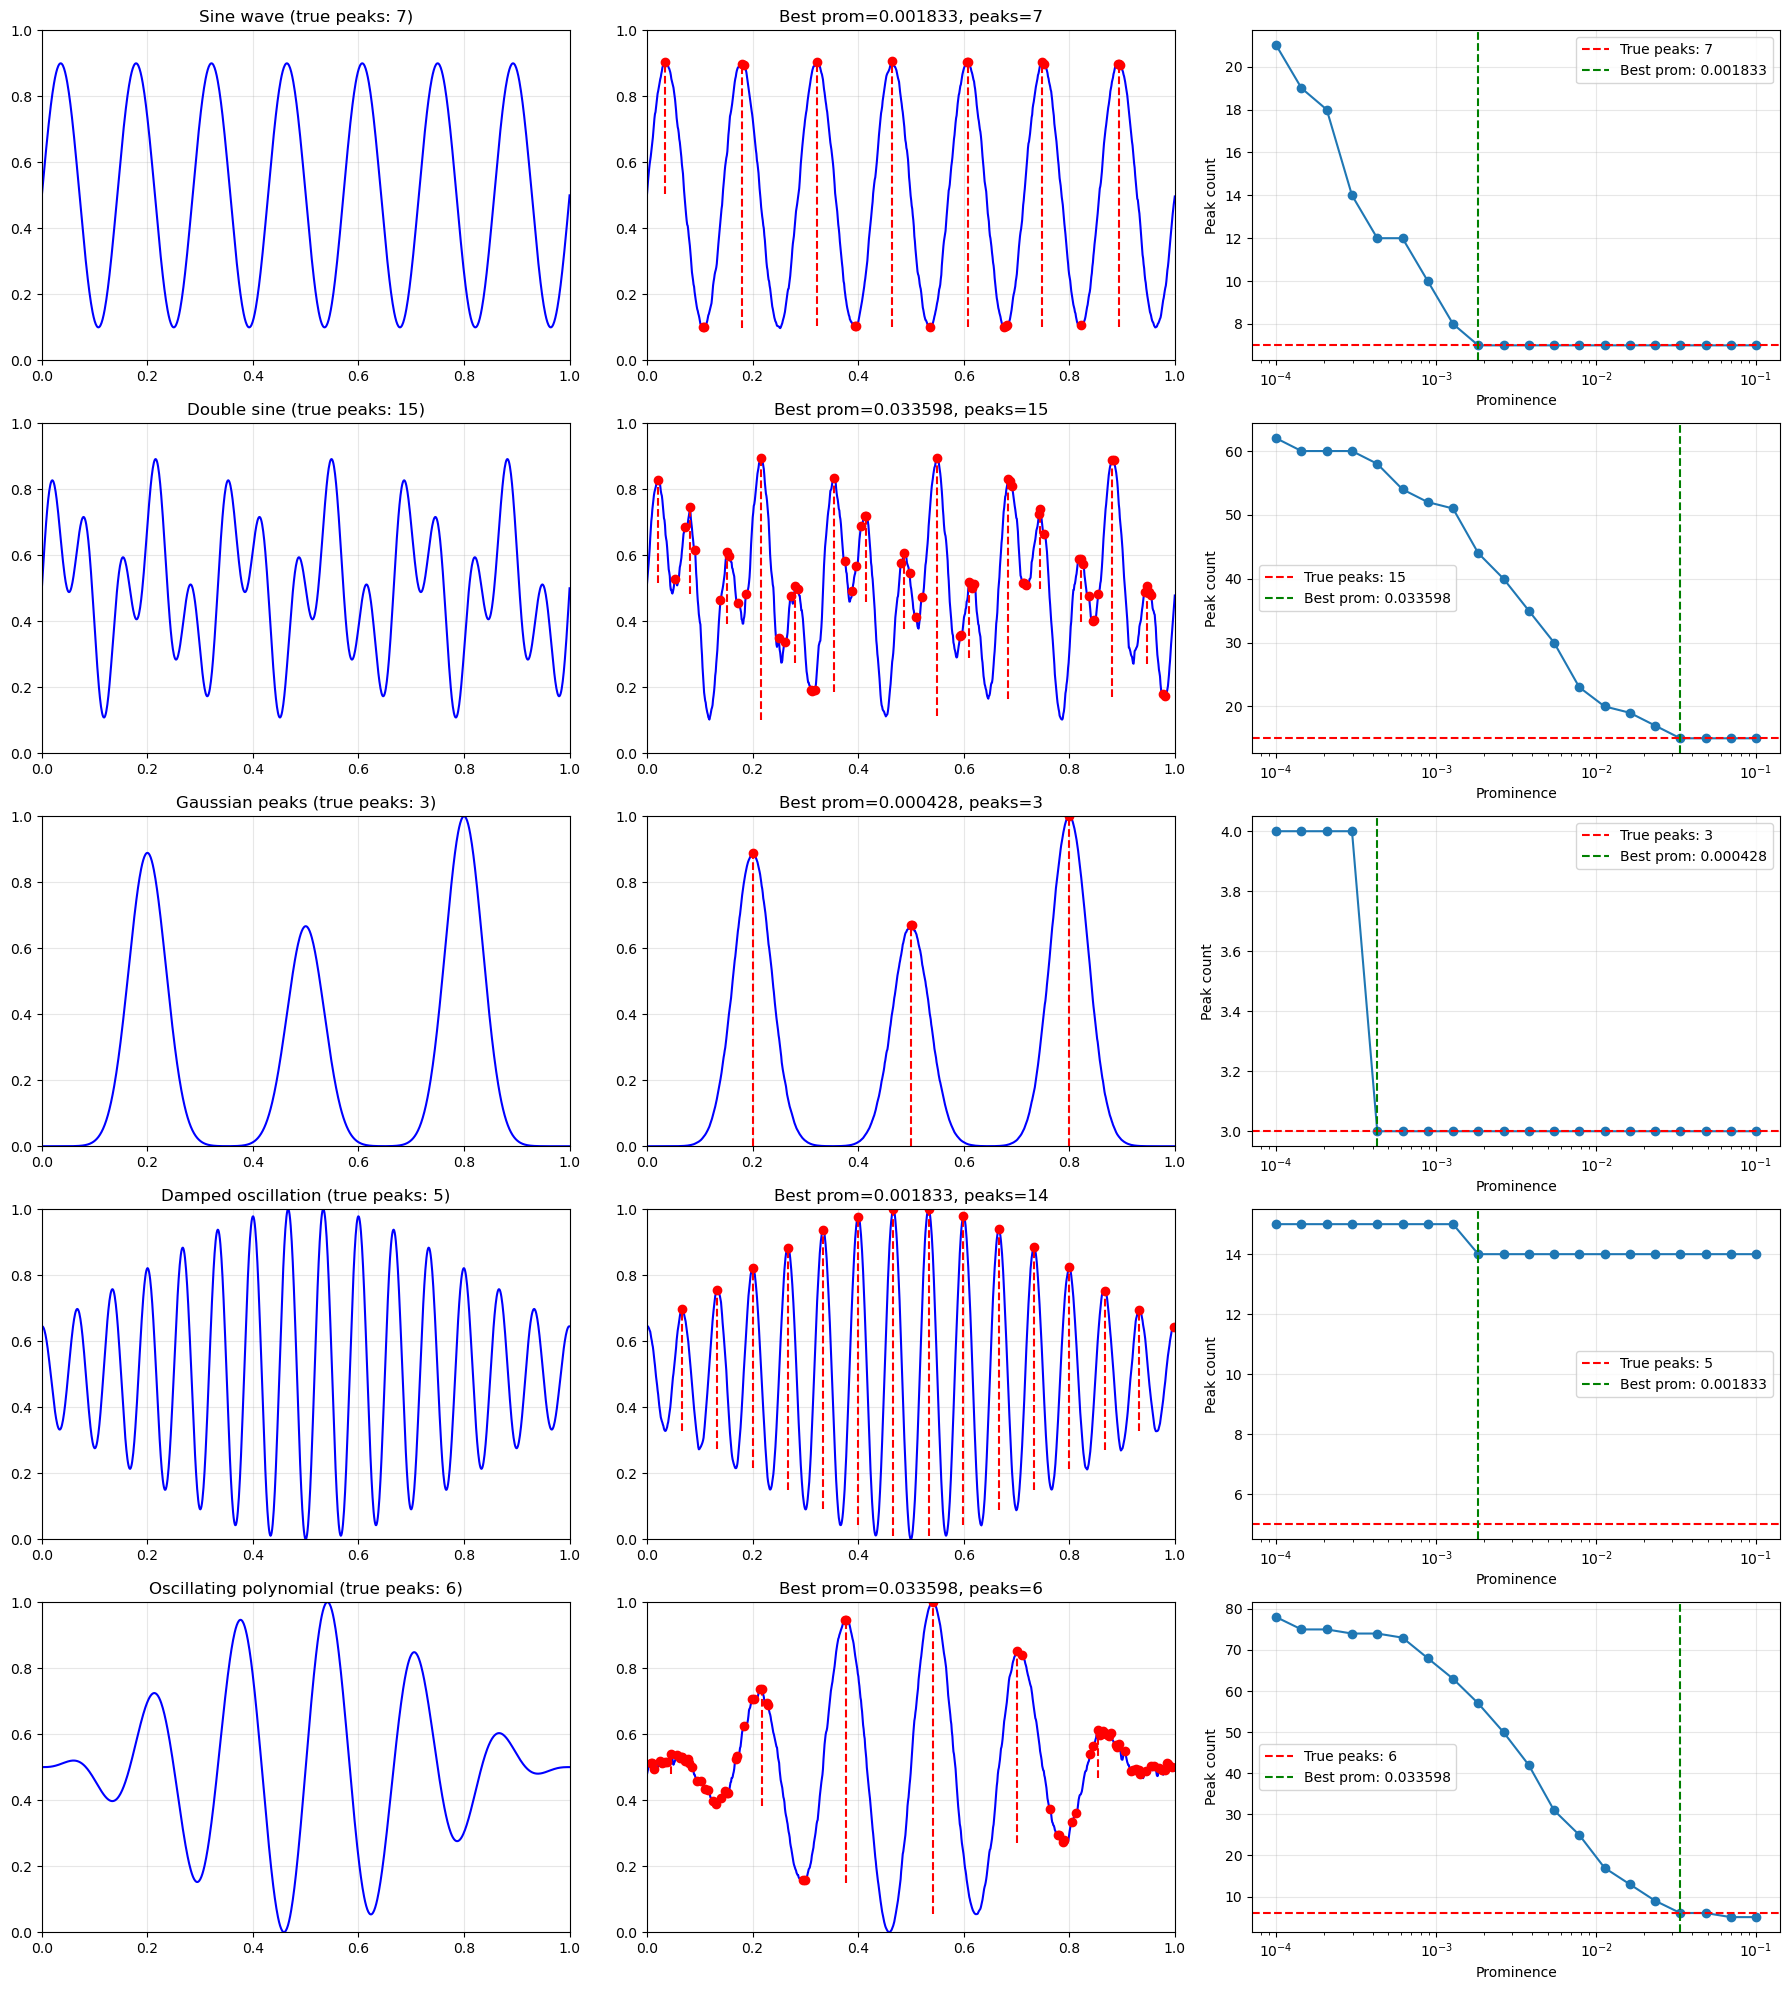

In [33]:
recommended_prominence = test_prominence_thresholds()

In [8]:
dist_tps, solns_all=turning_points.gen_profiles(params_file, n, m, seed, n_second_order, n_inputs, second_order_edge_idxs, initial_conditions, all_features, solver, stepsize_controller, t_points, dt,max_steps)

0
[Array([-0.95767404, -4.42344102, -0.81178903,  0.23851545,  2.50671983,
        3.69578794], dtype=float64), Array([-3.40969749,  3.22196664,  4.36304053,  3.5653223 ,  2.12491472,
        4.63707705, -3.22645281,  0.0797938 , -4.35707727, -1.19119925,
        2.6128398 ,  0.98987994, -4.46695801, -3.54018735, -4.65952519,
        4.45343421, -1.50677345, -3.66812326, -2.08718232, -4.07374758,
        3.95711248, -0.34161081,  0.80490757,  1.79278426,  2.20678375,
        0.78646823, -0.08974455,  4.52446826,  3.83498106,  0.81352021],      dtype=float64), Array([ 1.71192987,  2.57670611, -4.35635206,  4.15343702,  0.10532753,
        2.59833024,  0.28830426, -2.4884716 , -3.0044889 ,  0.82084354,
       -4.54985429,  2.21907592,  3.32807009, -0.62086941,  1.23246458],      dtype=float64)]
1
[Array([ 4.65325314, -2.30691003,  1.3033478 , -4.25006761,  4.49301304,
        3.24602627], dtype=float64), Array([-0.18733644, -4.3417702 ,  2.85190053, -3.18134056, -0.89042818,
       -0.74

(array([ 0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

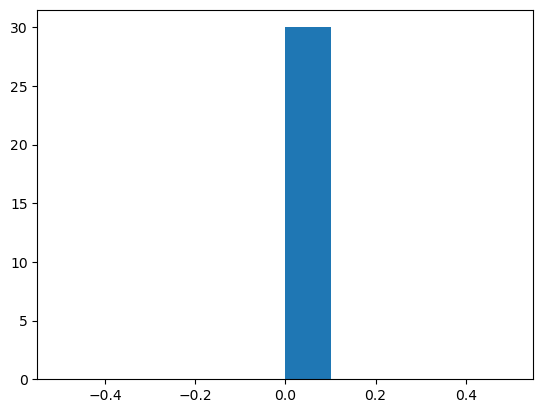

In [9]:
plt.hist(dist_tps)

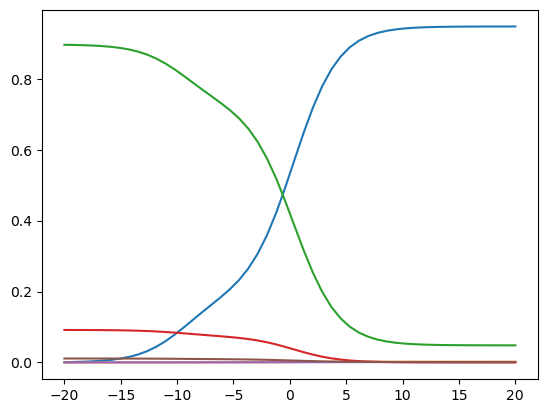

In [14]:
for i in range(n):
    plt.plot(all_features, (solns_all[4].T)[i])

# Testing turning point pipeline.

In [2]:
n=6
m=n*(n-1)//2
seeds=np.arange(1, 4001)
seeds = seeds.reshape(4, 1000)
initial_conditions=jnp.log(jnp.array([1/6, 1/6, 1/6, 1/6, 1/6, 1/6]))#jnp.log(jnp.array([1/6, 1/6, 1/6, 1/6, 1/6, 1/6]))
all_features=jnp.linspace(-20, 20, 100)
t_points=jnp.linspace(0, 20, 200)
solver= Kvaerno3()
stepsize_controller=PIDController(
    rtol=1e-6,     
    atol=1e-9,   
    dtmin=1e-11,   
    dtmax=1e-1     
    )
dt=0.1
n_second_order=2
n_inputs=1
max_steps=10000#000
params_file=f'data/turning_points/params_all_N0'
second_order_edge=jnp.array([[0, 1], [4, 1]])

In [3]:
dist, solns_all=turning_points_memory_efficient.gen_profiles_memory_efficient(params_file, n, m, seeds[n_second_order], n_second_order, n_inputs,second_order_edge, initial_conditions, all_features, solver, stepsize_controller, t_points, dt,max_steps)

number of params is 10000
seed 2001


KeyboardInterrupt: 

(36,)

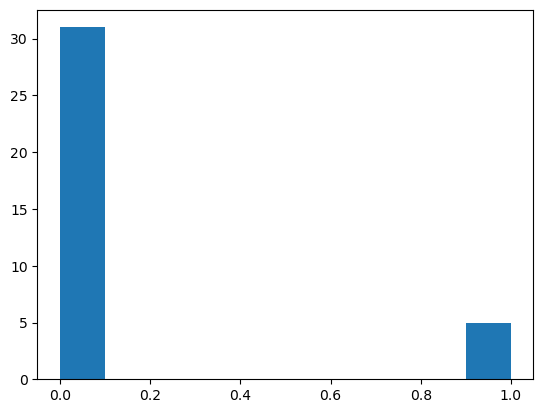

In [15]:
plt.hist(dist)
dist.shape

1

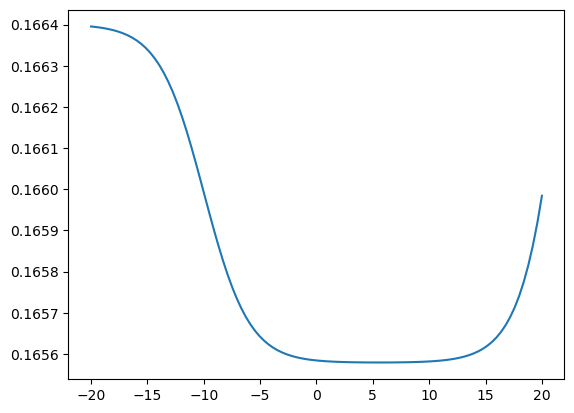

In [ ]:
plt.plot(all_features, solns_all[3].T[0])
#plt.plot(all_features, jnp.sum(jnp.log(solns_all)[3], axis=1))
turning_points_memory_efficient.count_turning_points(solns_all[3].T[0])

In [ ]:
turning_points_memory_efficient.count_turning_points(solns_all[4].T[1])

1

In [30]:
dist_file=f'data/turning_points/dist_N6_M15_S3_distributions'#f'data/turning_points/params_all_N3_S0'

f=open(dist_file, 'rb')
dist_test=pkl.load(f)
f.close()

In [31]:
prof_file=f'data/turning_points/dist_N6_M15_S3_profiles'
f=open(prof_file, 'rb')
prof_test=pkl.load(f)
f.close()

(array([0., 0., 0., 0., 0., 6., 0., 0., 0., 0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

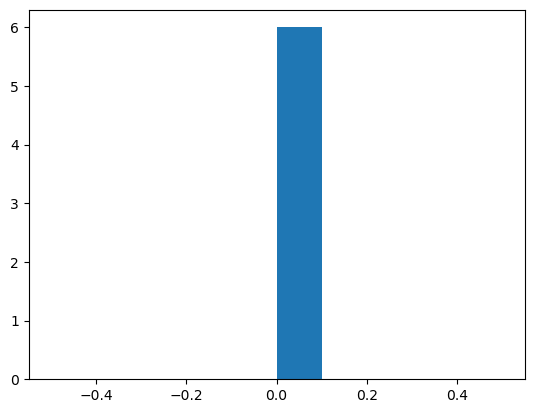

In [32]:
plt.hist(dist_test)

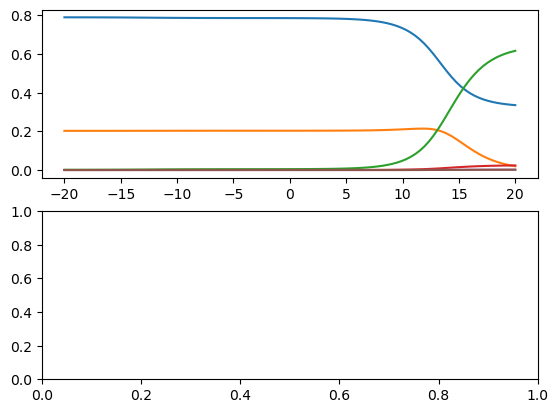

In [33]:
all_features=jnp.linspace(-20, 20, 100)
fig, axs=plt.subplots(2)
for i, prof in enumerate(prof_test):
    for species_prof in prof.T:
        axs[i].plot(all_features, species_prof)


# Plotting output

In [71]:
n=6
m=int(n*(n-1)/2)
    
n_profiles=1000
n_features=100
n_species=6

dataset=np.zeros((2, n_species * n_profiles))
profiles_all=[]

for n_second_order in range(2):
    suffix=f'task{n_second_order}'
    profiles_filename = f'data/turning_points/N{n}_M{m}_S{n_second_order}_profiles_{suffix}.txt'
    turning_points_filename = f'data/turning_points/N{n}_M{m}_S{n_second_order}_distributions_{suffix}.txt' 
    profiles=load_profiles_from_text(profiles_filename, n_profiles, n_features, n_species)
    profiles_all.append(profiles)
    turning_points=load_turning_points_from_text(turning_points_filename, n_profiles, n_species)
    turning_points=turning_points.flatten()
    dataset[n_second_order]=turning_points


(array([5750.,   21.,  181.,    0.,    6.,    0.,   30.,    0.,    6.,
           6.]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <BarContainer object of 10 artists>)

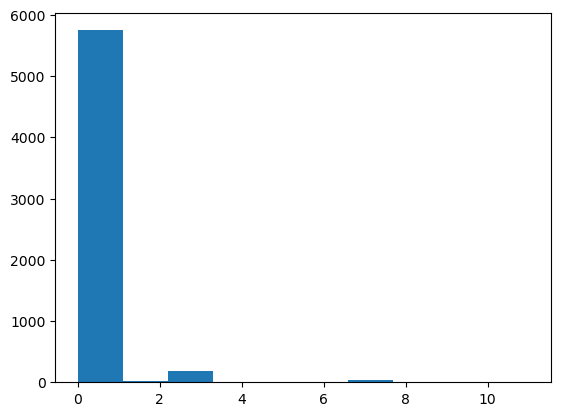

In [74]:
plt.hist(dataset[0])

In [77]:
np.argwhere(dataset[0] == 3) // 6

array([[  7],
       [  7],
       [  7],
       [  7],
       [  7],
       [  7],
       [ 15],
       [ 15],
       [ 15],
       [ 15],
       [ 15],
       [ 15],
       [ 18],
       [ 18],
       [ 18],
       [ 18],
       [ 18],
       [ 18],
       [ 32],
       [ 32],
       [ 32],
       [ 32],
       [ 32],
       [ 32],
       [ 54],
       [ 54],
       [ 54],
       [ 54],
       [ 54],
       [ 54],
       [114],
       [114],
       [114],
       [114],
       [114],
       [114],
       [127],
       [127],
       [127],
       [127],
       [127],
       [127],
       [194],
       [194],
       [194],
       [194],
       [194],
       [194],
       [213],
       [213],
       [213],
       [213],
       [213],
       [213],
       [248],
       [248],
       [248],
       [248],
       [248],
       [248],
       [251],
       [251],
       [251],
       [251],
       [251],
       [251],
       [270],
       [270],
       [270],
       [270],
       [270],
      

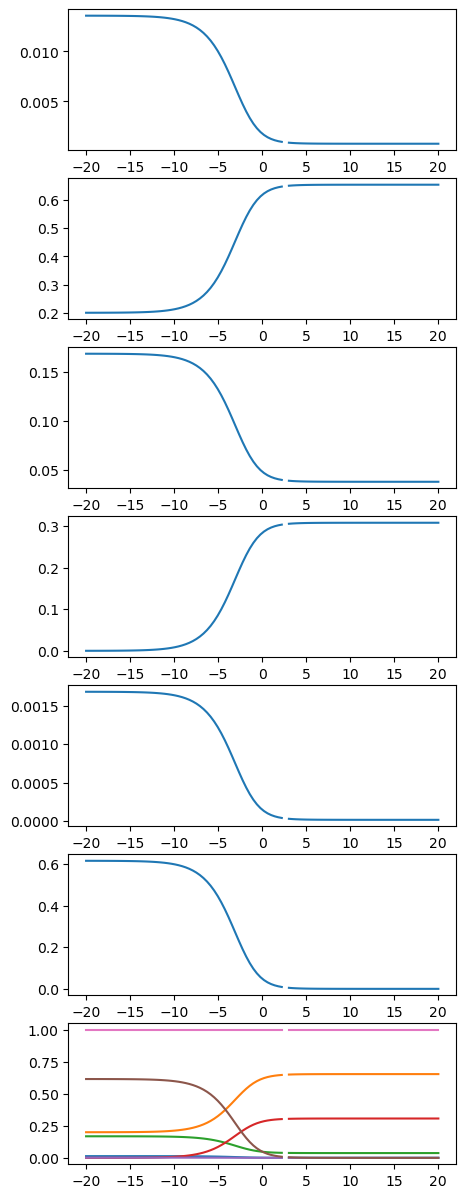

In [117]:
all_features=np.linspace(-20, 20, 100)
profiles_all[0].shape
fig, axs=plt.subplots(7, figsize=(5, 15))
for i in range(6):
    axs[i].plot(all_features, profiles_all[0][251].T[i])
    axs[6].plot(all_features, profiles_all[0][251].T[i])

axs[6].plot(all_features, np.sum(profiles_all[0][251], axis=1))

[15]
[15]
[10 20]
[inf]
[-inf -inf]


/var/folders/lf/7gzndb3s11g08rld41m9cfdc0000gn/T/ipykernel_18106/233093952.py:19: PeakPropertyWarning: some peaks have a width of 0
  width_peaks, _ = scipy.signal.find_peaks(data, width=min_width)
/var/folders/lf/7gzndb3s11g08rld41m9cfdc0000gn/T/ipykernel_18106/233093952.py:20: PeakPropertyWarning: some peaks have a width of 0
  width_troughs, _ = scipy.signal.find_peaks(-data, width=min_width)


np.int64(0)

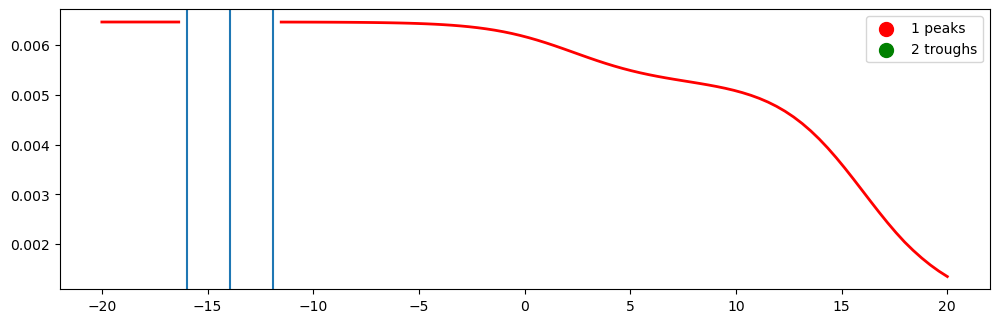

In [124]:
count_turning_points(profiles_all[0][7].T[4], all_features)

(array([5.468e+03, 2.690e+02, 2.900e+01, 1.880e+02, 4.000e+00, 1.100e+01,
        1.000e+00, 1.800e+01, 0.000e+00, 1.200e+01]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

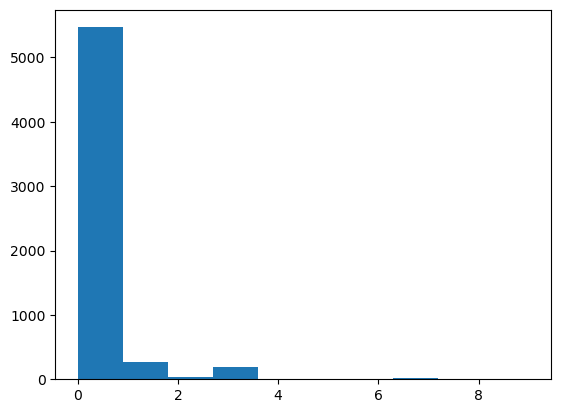

In [75]:
plt.hist(dataset[1])

# Reanalyzing data

In [ ]:
def count_turning_points(data,all_features, window_length=11, polyorder=2, min_width=5):
    
    if len(data) < window_length:
        window_length = max(min(len(data) - 2, 7), 3)
    window_length = window_length if window_length % 2 == 1 else window_length - 1
    polyorder = min(polyorder, window_length - 2)
    
    # Apply Savitzky-Golay filter to smooth the data
    data = savgol_filter(data, window_length, polyorder)
    min_prominence=0.1*np.max(data)
    
    # Find peaks based on prominence criterion
    prominence_peaks, properties_prom_peaks = scipy.signal.find_peaks(data, prominence=min_prominence)
    prominence_troughs, properties_prom_troughs= scipy.signal.find_peaks(-data, prominence=min_prominence)

    print('prominence peaks:',properties_prom_peaks['prominences'])
    print('prominence troughs: ',properties_prom_troughs['prominences'])

    #print(prominence_peaks)
    
    # Find peaks based on width criterion
    width_peaks, properties_width_peaks = scipy.signal.find_peaks(data, width=min_width)
    width_troughs, properties_width_troughs = scipy.signal.find_peaks(-data, width=min_width)

    print('width peaks:', properties_width_peaks['widths'])
    print('width troughs: ', properties_width_troughs['widths'])

    peaks, _ = scipy.signal.find_peaks(data)
    troughs, _ = scipy.signal.find_peaks(-data)
    
    # Combine unique peaks and troughs from both criteria
    all_peaks = np.unique(np.concatenate((prominence_peaks, width_peaks)))
    all_troughs = np.unique(np.concatenate((prominence_troughs, width_troughs)))

    bad_points = ~np.isfinite(data)
    
    # Expand the mask to include neighbors of bad points
    bad_points_expanded = bad_points.copy()
    
    # Mark neighbors of bad points as bad too
    for i in range(len(bad_points)):
        if bad_points[i]:
            # Mark left neighbor as bad
            if i > 0:
                bad_points_expanded[i-1] = True
            # Mark right neighbor as bad  
            if i < len(bad_points) - 1:
                bad_points_expanded[i+1] = True
    
    # FILTER PEAKS AND TROUGHS
    # Remove peaks that are at bad points or next to bad points
    valid_peaks = all_peaks[~bad_points_expanded[all_peaks]]
    valid_troughs = all_troughs[~bad_points_expanded[all_troughs]]

    finite_peaks = np.isfinite(data[valid_peaks])  # boolean array, True for finite values
    count_finite_peaks = np.sum(finite_peaks)

    # Count finite values in all_troughs
    finite_troughs = np.isfinite(data[valid_troughs])
    count_finite_troughs = np.sum(finite_troughs)

    #    Total finite values in both arrays
    total_finite = count_finite_peaks + count_finite_troughs

    return total_finite

In [71]:
n=6
m=int(n*(n-1)/2)
    
n_profiles=1000
n_features=100
n_species=6

dataset=np.zeros((2, n_species * n_profiles))
profiles_all=[]
all_features = jnp.linspace(-20, 20, 100)

for n_second_order in range(2):
    suffix=f'task{n_second_order}'
    profiles_filename = f'data/turning_points/N{n}_M{m}_S{n_second_order}_profiles_{suffix}.txt'
    turning_points_filename = f'data/turning_points/N{n}_M{m}_S{n_second_order}_distributions_{suffix}.txt' 
    profiles=load_profiles_from_text(profiles_filename, n_profiles, n_features, n_species)
    profiles_all.append(profiles)

In [72]:
turning_points_all = []
pos_idxs_all=[]
for i, solns in enumerate(profiles_all):
    #print(solns.shape)
    turning_points=[]
    pos_idxs=[]
    
    for j, profiles in enumerate(solns):
        for k, species_prof in enumerate(profiles.T):
            #print(species_prof.shape)
            n_tps=count_turning_points(species_prof, all_features)
            if int(n_tps) > 0:
                pos_idxs.append(j)
            turning_points.append(int(n_tps))
    turning_points_all.append(np.array(turning_points))
    print(len(np.array(turning_points)))
    pos_idxs_all.append(np.array(pos_idxs))

prominence peaks: []
prominence troughs:  []
width peaks: []
width troughs:  []
[]
[]
prominence peaks: []
prominence troughs:  []
width peaks: []
width troughs:  []
[]
[]
prominence peaks: []
prominence troughs:  []
width peaks: []
width troughs:  []
[]
[]
prominence peaks: []
prominence troughs:  []
width peaks: []
width troughs:  []
[]
[]
prominence peaks: []
prominence troughs:  []
width peaks: []
width troughs:  []
[]
[]
prominence peaks: []
prominence troughs:  []
width peaks: []
width troughs:  []
[]
[]
prominence peaks: []
prominence troughs:  []
width peaks: []
width troughs:  []
[]
[]
prominence peaks: []
prominence troughs:  []
width peaks: []
width troughs:  []
[]
[]
prominence peaks: []
prominence troughs:  []
width peaks: []
width troughs:  []
[]
[]
prominence peaks: []
prominence troughs:  []
width peaks: []
width troughs:  []
[]
[]
prominence peaks: []
prominence troughs:  []
width peaks: []
width troughs:  []
[]
[]
prominence peaks: []
prominence troughs:  []
width pea

/var/folders/lf/7gzndb3s11g08rld41m9cfdc0000gn/T/ipykernel_73978/3771716147.py:22: PeakPropertyWarning: some peaks have a width of 0
  width_peaks, properties_width_peaks = scipy.signal.find_peaks(data, width=min_width)
/var/folders/lf/7gzndb3s11g08rld41m9cfdc0000gn/T/ipykernel_73978/3771716147.py:23: PeakPropertyWarning: some peaks have a width of 0
  width_troughs, properties_width_troughs = scipy.signal.find_peaks(-data, width=min_width)


prominence peaks: []
prominence troughs:  []
width peaks: []
width troughs:  []
[]
[]
prominence peaks: []
prominence troughs:  []
width peaks: []
width troughs:  []
[]
[]
prominence peaks: []
prominence troughs:  []
width peaks: []
width troughs:  []
[]
[]
prominence peaks: []
prominence troughs:  []
width peaks: []
width troughs:  []
[]
[]
prominence peaks: []
prominence troughs:  []
width peaks: []
width troughs:  []
[]
[]
prominence peaks: []
prominence troughs:  []
width peaks: []
width troughs:  []
[]
[]
prominence peaks: []
prominence troughs:  []
width peaks: []
width troughs:  []
[]
[]
prominence peaks: []
prominence troughs:  []
width peaks: []
width troughs:  []
[]
[]
prominence peaks: []
prominence troughs:  []
width peaks: []
width troughs:  []
[]
[]
prominence peaks: []
prominence troughs:  []
width peaks: []
width troughs:  []
[]
[]
prominence peaks: []
prominence troughs:  []
width peaks: []
width troughs:  []
[]
[]
prominence peaks: []
prominence troughs:  []
width pea

(array([5.971e+03, 0.000e+00, 0.000e+00, 2.500e+01, 0.000e+00, 0.000e+00,
        3.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

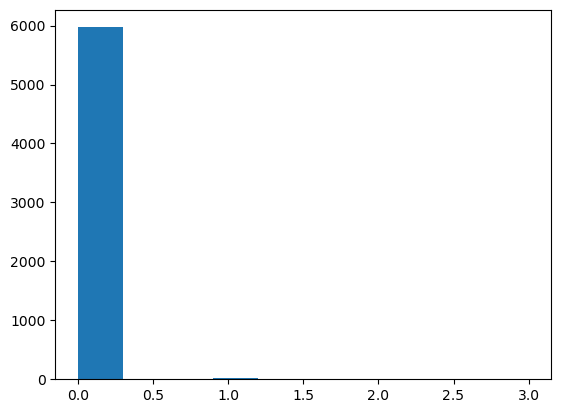

In [73]:
plt.hist(turning_points_all[0])

In [74]:
pos_idxs_all[0]

array([ 11,  24,  70, 109, 117, 129, 129, 217, 299, 303, 399, 510, 510,
       592, 683, 683, 728, 728, 759, 835, 873, 873, 885, 885, 906, 919,
       969, 969, 969])

In [75]:
pos_idxs_all

[array([ 11,  24,  70, 109, 117, 129, 129, 217, 299, 303, 399, 510, 510,
        592, 683, 683, 728, 728, 759, 835, 873, 873, 885, 885, 906, 919,
        969, 969, 969]),
 array([  5,  18,  18,  18,  43,  56,  70,  75,  75,  80,  80, 103, 103,
        109, 109, 109, 122, 135, 144, 144, 158, 175, 178, 178, 183, 183,
        183, 184, 184, 184, 184, 186, 203, 203, 207, 210, 212, 212, 212,
        212, 212, 212, 215, 215, 217, 217, 221, 227, 227, 227, 227, 235,
        235, 245, 253, 266, 275, 275, 286, 286, 286, 290, 294, 298, 307,
        314, 317, 317, 317, 317, 317, 331, 331, 332, 360, 360, 364, 368,
        368, 368, 382, 397, 398, 401, 407, 407, 431, 433, 456, 461, 461,
        477, 477, 477, 477, 477, 477, 483, 485, 489, 493, 503, 506, 506,
        506, 513, 521, 526, 526, 535, 546, 550, 555, 572, 572, 572, 572,
        581, 584, 591, 632, 632, 657, 657, 669, 670, 683, 684, 684, 684,
        684, 684, 684, 685, 685, 703, 703, 703, 703, 710, 717, 717, 717,
        717, 721, 727, 727

In [76]:
print(profiles_all[0].shape)

(1000, 100, 6)


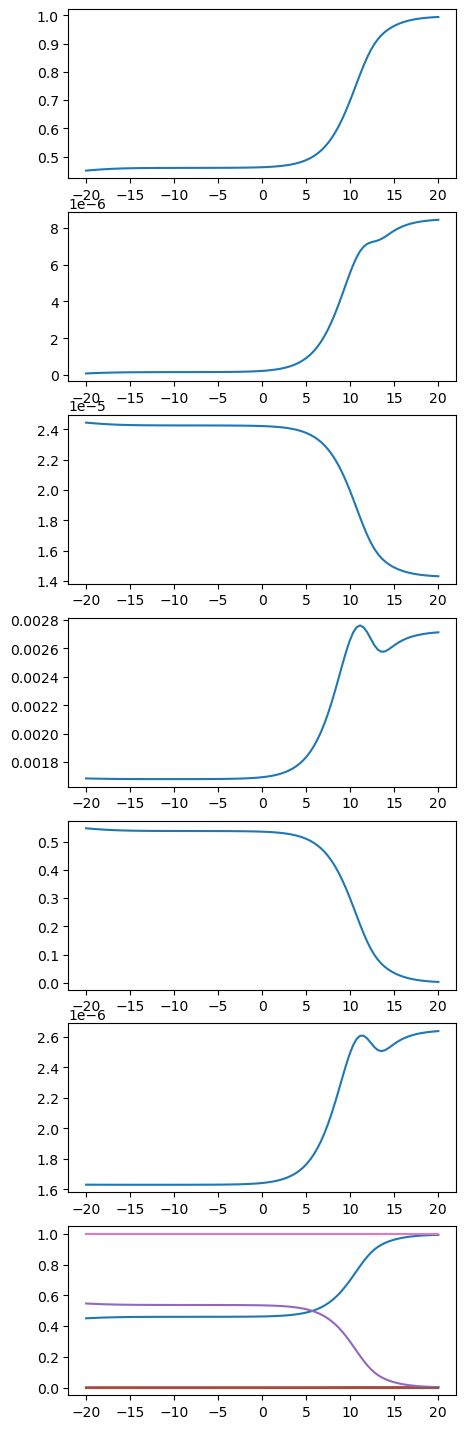

In [136]:
all_features=np.linspace(-20, 20, 100)
fig, axs=plt.subplots(7, figsize=(5, 18))
for i in range(6):
    axs[i].plot(all_features, profiles_all[0][728].T[i])
    axs[6].plot(all_features, profiles_all[0][728].T[i])

axs[6].plot(all_features, np.sum(profiles_all[0][728], axis=1))

[0.00168515 0.00168462 0.00168411 0.00168362 0.00168318 0.00168277
 0.00168241 0.00168209 0.00168181 0.00168157 0.00168136 0.00168118
 0.00168104 0.00168091 0.00168081 0.00168072 0.00168065 0.0016806
 0.00168055 0.00168052 0.00168049 0.00168047 0.00168046 0.00168045
 0.00168045 0.00168045 0.00168047 0.00168048 0.00168051 0.00168054
 0.00168059 0.00168064 0.00168071 0.0016808  0.00168091 0.00168104
 0.0016812  0.0016814  0.00168164 0.00168194 0.0016823  0.00168275
 0.0016833  0.00168397 0.00168478 0.00168578 0.00168701 0.00168851
 0.00169033 0.00169257 0.0016953  0.00169864 0.0017027  0.00170767
 0.00171372 0.00172108 0.00173003 0.00174091 0.00175408 0.00177002
 0.00178925 0.00181237 0.00184006 0.00187304 0.00191211 0.00195802
 0.00201147 0.00207297 0.00214272 0.00222036 0.00230478 0.00239386
 0.0024842  0.00257106 0.00264849 0.00270989 0.00274915 0.00276224
 0.00274899 0.00271444 0.00266852 0.00262382 0.00259143 0.00257708
 0.00257964 0.00259327 0.00261131 0.00262924 0.00264512 0.00265

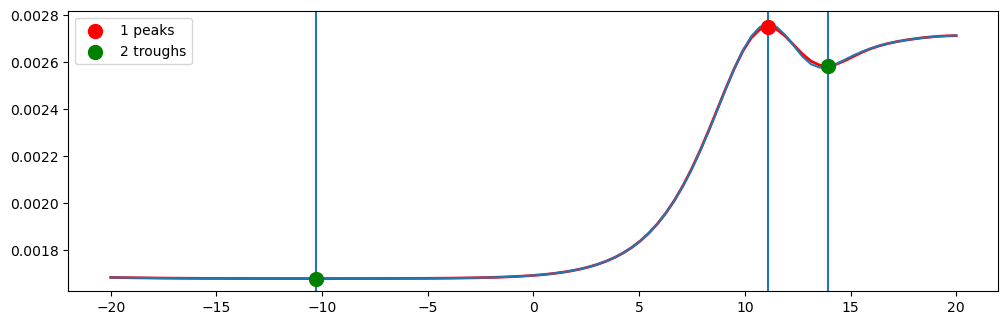

In [135]:
count=count_turning_points_w_plot(profiles_all[0][728].T[3], all_features)
plt.plot(all_features, profiles_all[0][728].T[3])
print(count)

In [549]:
count2=count_turning_points(profiles_all[0][217].T[2], all_features)
print(count2)

prominence peaks: [0.00571675]
prominence troughs:  []
width peaks: [19.91838842]
width troughs:  []
[0.03228281]
[]
1


11, 728, 683, 759, 835 --> tps found

# Studying steady states for parameters with strange behaviors 

it seems the problem was in creating the W_ij matrix; i was doing E_j-B_ij not E_i - B_ij.

In [117]:
pos_idxs_all=[np.array([ 11,  24,  70, 109, 117, 129, 129, 217, 299, 303, 399, 510, 510,
        592, 683, 683, 728, 728, 759, 835, 873, 873, 885, 885, 906, 919,
        969, 969, 969]),
 np.array([  5,  18,  18,  18,  43,  56,  70,  75,  75,  80,  80, 103, 103,
        109, 109, 109, 122, 135, 144, 144, 158, 175, 178, 178, 183, 183,
        183, 184, 184, 184, 184, 186, 203, 203, 207, 210, 212, 212, 212,
        212, 212, 212, 215, 215, 217, 217, 221, 227, 227, 227, 227, 235,
        235, 245, 253, 266, 275, 275, 286, 286, 286, 290, 294, 298, 307,
        314, 317, 317, 317, 317, 317, 331, 331, 332, 360, 360, 364, 368,
        368, 368, 382, 397, 398, 401, 407, 407, 431, 433, 456, 461, 461,
        477, 477, 477, 477, 477, 477, 483, 485, 489, 493, 503, 506, 506,
        506, 513, 521, 526, 526, 535, 546, 550, 555, 572, 572, 572, 572,
        581, 584, 591, 632, 632, 657, 657, 669, 670, 683, 684, 684, 684,
        684, 684, 684, 685, 685, 703, 703, 703, 703, 710, 717, 717, 717,
        717, 721, 727, 727, 741, 759, 764, 776, 776, 777, 791, 791, 792,
        792, 792, 796, 802, 812, 818, 831, 838, 839, 847, 857, 857, 866,
        866, 866, 867, 877, 877, 877, 877, 881, 888, 888, 904, 904, 916,
        924, 924, 935, 971, 975, 975, 975, 979, 979, 994])]

In [118]:
params_file=f'data/turning_points/params_all_N0'#f'data/turning_points/params_all_N3_S0'

f=open(params_file, 'rb')
params_all=pkl.load(f)
f.close()

params_bad=[]
for i in pos_idxs_all[0]:
    params_bad.append(params_all[i])

In [126]:
n = 6
m = n * (n - 1) // 2
seeds = np.arange(1, 4001)
seeds = seeds.reshape(4, 1000)
initial_conditions = jnp.log(jnp.array([1/6, 1/6, 1/6, 1/6, 1/6, 1/6]))
all_features = jnp.linspace(-20, 20, 100)
t_points = jnp.linspace(0, 20, 200)
solver = Kvaerno3()
stepsize_controller = PIDController(
    rtol=1e-6,
    atol=1e-9,
    dtmin=1e-11,
    dtmax=1e-1
)
dt = 0.1

max_steps = 1000#0000

n_inputs = 1
all_features = jnp.linspace(-20, 20, 100)

In [127]:
# Calculate n_second_order from the edges (for compatibility)
edges_list=[[0, 0]]#[[0, 1], [4, 1]]
second_order_edge = jnp.array(edges_list)
if len(edges_list) == 1 and edges_list[0] == [0, 0]:
    n_second_order = 0  # Special case for dummy edge
else:
    n_second_order = len(edges_list)
print(n_second_order)
i_test=16
idx_test=pos_idxs_all[0][i_test]
print(idx_test)
seed=seeds[0][idx_test]
print(seed)
rxn=random_rxn_net(n, m, int(seed), n_second_order, n_inputs, test=False, A=None, second_order_edge_idxs=second_order_edge, F_a_idxs=None)

0
728
729


In [128]:
E=params_all[idx_test][0]#params_bad[i_test][0]
B=params_all[idx_test][1]#params_bad[i_test][1]
F=params_all[idx_test][2]#params_bad[i_test][2]

params=(E, B, F,)

In [129]:
profile=turning_points_inputs.profile(rxn, params, initial_conditions, all_features, solver, stepsize_controller, t_points, dt, max_steps)

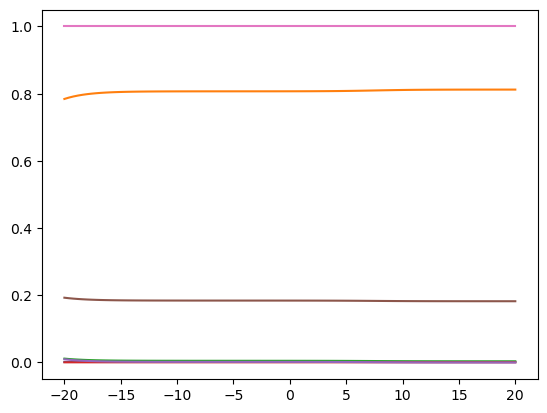

In [130]:
for prof in profile.T:
    plt.plot(all_features, prof)
plt.plot(all_features, np.sum(profile, axis=1))

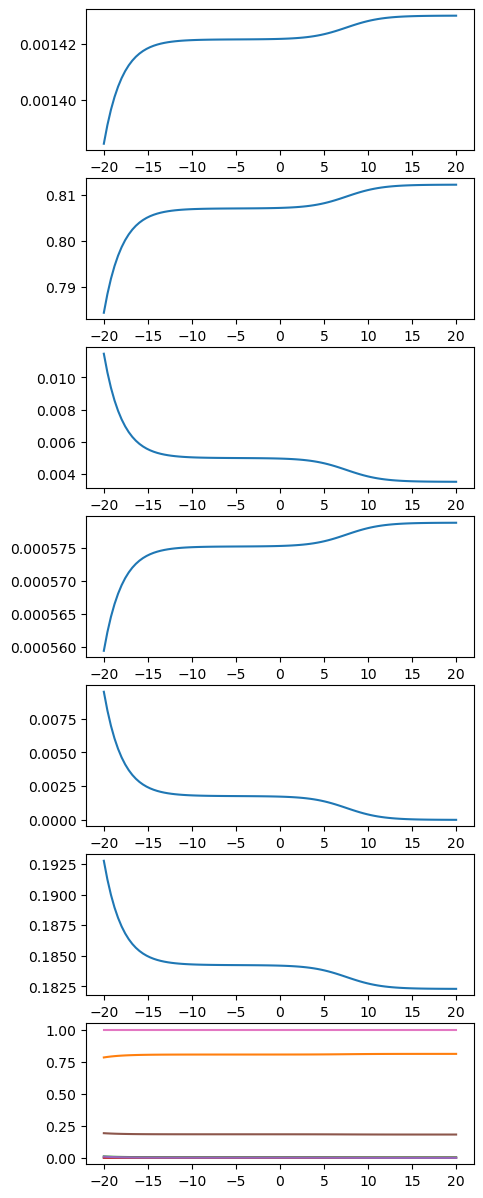

In [131]:
fig, axs=plt.subplots(7, figsize=(5, 15))
for i in range(6):
    axs[i].plot(all_features, profile.T[i])
    axs[6].plot(all_features, profile.T[i])
    #axs[i].plot(all_features, profiles_all[0][11].T[i])
    #axs[6].plot(all_features, profiles_all[0][11].T[i])

axs[6].plot(all_features, np.sum(profiles_all[0][11], axis=1))

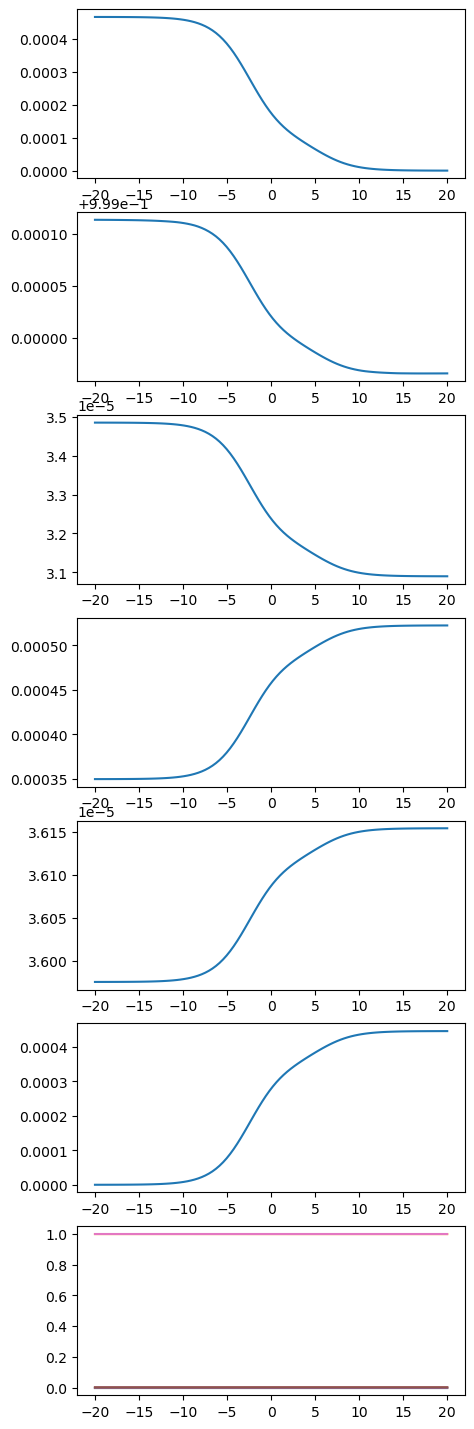

In [101]:
all_features=np.linspace(-20, 20, 100)
fig, axs=plt.subplots(7, figsize=(5, 18))
for i in range(6):
    axs[i].plot(all_features, profiles_all[0][idx_test].T[i])
    axs[6].plot(all_features, profiles_all[0][idx_test].T[i])

axs[6].plot(all_features, np.sum(profiles_all[0][idx_test], axis=1))

In [102]:
rxn.rxn_net_dynamics(1, initial_conditions, (E, B, F, -7,))

Array([-1.27140594e+03, -1.94735263e-01,  8.06894984e+03, -5.72028554e+03,
       -8.39894496e+02, -2.37169137e+02], dtype=float64)

In [103]:
p_A, p_B, p_C, p_D, p_E, p_F=jnp.exp(initial_conditions)[0], jnp.exp(initial_conditions)[1], jnp.exp(initial_conditions)[2], jnp.exp(initial_conditions)[3], jnp.exp(initial_conditions)[4], jnp.exp(initial_conditions)[5]

In [25]:
#For -7 
W=jnp.array([[0.00000000e+00, 1.82225391e-02, 5.89757828e-01, 4.99603596e-03,
  1.62863309e-02, 3.66929685e-03],
 [4.18678853e-03, 0.00000000e+00, 6.44007926e-02, 2.32288102e-01,
  8.74197517e-03, 2.18131818e-02],
 [1.13643699e+02, 1.21123753e-01, 0.00000000e+00, 1.51331776e+00, 2.31992265e+02, 8.86191022e+00],
 [4.61228625e-04, 8.34069796e-04, 5.93569882e-03, 0.00000000e+00,
  2.18040423e-04, 2.01573483e-01],
 [1.15993153e+00, 3.27271156e-04, 6.30285556e-02, 1.43036807e-01,
  0.00000000e+00, 3.52736298e-03],
 [7.83773016e-02, 7.49983534e+00, 1.08990447e-02, 2.88886308e-02,
  1.55024665e-03, 0.00000000e+00]])

In [ ]:
def test(t, y, args):

    edge_idxs=jnp.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

    E, B, F, F_a=args[0], args[1], args[2], args[3]
    print(E)
    print(B)
    print(F)
    p_A, p_B, p_C, p_D, p_E, p_F=jnp.exp(y)[0], jnp.exp(y)[1], jnp.exp(y)[2], jnp.exp(y)[3], jnp.exp(y)[4], jnp.exp(y)[5]
    E_A, E_B, E_C, E_D, E_E, E_F=E[0], E[1], E[2], E[3], E[4], E[5]

    #input edge is 0 --> 2  (A --> C)

    B_AB, B_AC, B_AD, B_AE, B_AF, B_BA, B_BC, B_BD, B_BE, B_BF, B_CA, B_CB, B_CD, B_CE, B_CF, B_DA, B_DB, B_DC, B_DE, B_DF, B_EA, B_EB, B_EC, B_ED, B_EF, B_FA, B_FB, B_FC, B_FD, B_FE=B[0], B[1], B[2], B[3], B[4], B[5], B[6], B[7], B[8], B[9], B[10], B[11], B[12], B[13], B[14], B[15], B[16], B[17], B[18], B[19], B[20], B[21], B[22], B[23], B[24], B[25], B[26], B[27], B[28], B[29]
    F_AB, F_AC, F_AD, F_AE, F_AF, F_BC, F_BD, F_BE, F_BF, F_CD, F_CE, F_CF, F_DE, F_DF, F_EF=F[0], F[1], F[2], F[3], F[4], F[5], F[6], F[7], F[8], F[9], F[10], F[11], F[12], F[13],  F[14]
    F_BA, F_CA, F_DA, F_EA, F_FA, F_CB, F_DB, F_EB, F_FB, F_DC, F_EC, F_FC, F_ED, F_FD, F_FE=-F[0], -F[1], -F[2], -F[3], -F[4], -F[5], -F[6], -F[7], -F[8], -F[9], -F[10], -F[11], -F[12], -F[13], -F[14]

    W_AB, W_AC, W_AD, W_AE, W_AF=jnp.exp(E_A-B_AB+0.5*F_AB), jnp.exp(E_A-B_AC+0.5*F_AC+0.5*F_a), jnp.exp(E_A-B_AD+0.5*F_AD), jnp.exp(E_A-B_AE+0.5*F_AE), jnp.exp(E_A-B_AF+0.5*F_AF)
    W_BA, W_CA, W_DA, W_EA, W_FA=jnp.exp(E_B-B_BA+0.5*F_BA), jnp.exp(E_C-B_CA+0.5*F_CA-0.5*F_a), jnp.exp(E_D-B_DA+0.5*F_DA), jnp.exp(E_E-B_EA+0.5*F_EA), jnp.exp(E_F-B_FA+0.5*F_FA)

    W_BC, W_BD, W_BE, W_BF=jnp.exp(E_B-B_BC+0.5*F_BC), jnp.exp(E_B-B_BD+0.5*F_BD), jnp.exp(E_B-B_BE+0.5*F_BE), jnp.exp(E_B-B_BF+0.5*F_BF)
    W_CB, W_DB, W_EB, W_FB=jnp.exp(E_C-B_CB+0.5*F_CB), jnp.exp(E_D-B_DB+0.5*F_DB), jnp.exp(E_E-B_EB+0.5*F_EB), jnp.exp(E_F-B_FB+0.5*F_FB)

    W_CD, W_CE, W_CF=jnp.exp(E_C-B_CD+0.5*F_CD), jnp.exp(E_C-B_CE+0.5*F_CE), jnp.exp(E_C-B_CF+0.5*F_CF)
    W_DC, W_EC, W_FC=jnp.exp(E_D-B_DC+0.5*F_DC), jnp.exp(E_E-B_EC+0.5*F_EC), jnp.exp(E_F-B_FC+0.5*F_FC)

    W_DE, W_DF=jnp.exp(E_D-B_DE+0.5*F_DE), jnp.exp(E_D-B_DF+0.5*F_DF)
    W_ED, W_FD=jnp.exp(E_E-B_ED+0.5*F_ED), jnp.exp(E_F-B_FD+0.5*F_FD)

    W_EF=jnp.exp(E_E-B_EF+0.5*F_EF)
    W_FE=jnp.exp(E_F-B_FE+0.5*F_FE)
    '''
    W_AB, W_AC, W_AD, W_AE, W_AF=W[0][1], W[0][2], W[0][3], W[0][4], W[0][5]
    W_BA, W_CA, W_DA, W_EA, W_FA=W[1][0], W[2][0], W[3][0], W[4][0], W[5][0]

    W_BC, W_BD, W_BE, W_BF=W[1][2], W[1][3], W[1][4], W[1][5]
    W_CB, W_DB, W_EB, W_FB=W[2][1], W[3][1], W[4][1], W[5][1]

    W_CD, W_CE, W_CF=W[2][3], W[2][4], W[2][5]
    W_DC, W_EC, W_FC=W[3][2], W[4][2], W[5][2]

    W_DE, W_DF=W[3][4], W[3][5]
    W_ED, W_FD=W[4][3], W[5][3]

    W_EF=W[4][5]
    W_FE=W[5][4]
    '''

    print(W[0][1])
    print(W_AB)
    dAdt=p_B*W_AB + p_C*W_AC+p_D*W_AD+p_E*W_AE+p_F*W_AF-p_A*(W_BA+W_CA + W_DA + W_EA + W_FA)
    dBdt=p_A*W_BA + p_C*W_BC+p_D*W_BD+p_E*W_BE+p_F*W_BF-p_B*(W_AB+W_CB + W_DB + W_EB + W_FB)
    dCdt=p_A*W_CA + p_B*W_CB + p_D*W_CD+p_E*W_CE+p_F*W_CF-p_C*(W_AC+W_BC + W_DC + W_EC + W_FC)
    dDdt=p_A*W_DA + p_B*W_DB + p_C*W_DC+p_E*W_DE+p_F*W_DF-p_D*(W_AD+W_BD + W_CD + W_ED + W_FD)
    dEdt=p_A*W_EA + p_B*W_EB + p_C*W_EC+p_D*W_ED+p_F*W_EF-p_E*(W_AE+W_BE + W_CE + W_DE  + W_FE)
    dFdt=p_A*W_FA + p_B*W_FB + p_C*W_FC+p_D*W_FD+p_E*W_FE-p_F*(W_AF+W_BF+ W_CF + W_DF + W_EF)

    return jnp.array([dAdt/p_A, dBdt/p_B, dCdt/p_C, dDdt/p_D, dEdt/p_E, dFdt/p_F])

In [116]:
rxn.F_a_idxs

Array([[5, 0]], dtype=int64)

In [ ]:
test(0, initial_conditions, (E, B, F, -6,))

[-0.11244403 -3.19410454  4.1368418  -0.75907854 -0.2664864  -0.09845242]
[ 3.99231199  3.5470381   4.56517444 -2.66993139  0.19396661  4.68804284
 -0.90370547 -2.70624572 -1.20348914 -1.63969879 -1.52754562  2.89004813
 -2.09375862 -4.27103824  4.78165857  1.94524507  3.1020996   0.38861733
 -4.18894069 -0.66215538  0.57437223  2.13032213  4.07067287  1.31828499
  0.94609842 -2.7326434   1.30509407  2.90711323  4.65951623 -2.48092019]
[-4.1441799  -3.40796866 -4.97577149  3.56756324  4.55531444  3.16075366
 -3.23839413 -1.10633994  0.55787294  4.87883206 -3.85292962  4.62951883
  2.24216285  4.7664597  -0.77821333]
0.0182225391
0.0020769683688492456


Array([-5.24079961e+04, -1.94735263e-01,  5.89735780e+04, -5.72028554e+03,
       -8.39894496e+02, -5.20712888e+00], dtype=float64)

Array([-1.27140594e+03, -1.94735263e-01,  8.06894984e+03, -5.72028554e+03,
       -8.39894496e+02, -2.37169137e+02], dtype=float64)

In [112]:
soln=rxn.integrate(solver, stepsize_controller, t_points, dt, initial_conditions, (E, B, F, -7,), max_steps)

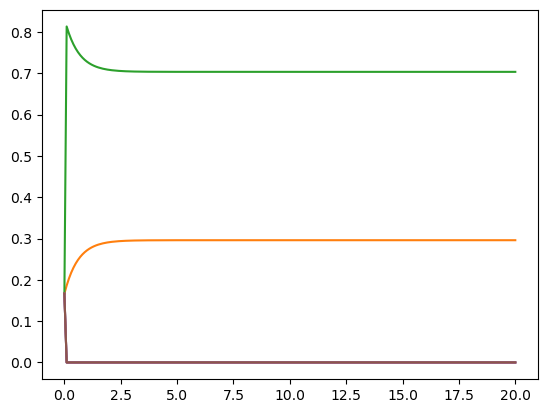

In [113]:
plt.plot(soln.ts, jnp.exp(soln.ys))

In [114]:
test_soln=diffeqsolve(ODETerm(test), solver=solver, stepsize_controller=stepsize_controller, t0=t_points[0], t1=t_points[-1], dt0=dt, y0=initial_conditions, args=(E,B, F, -7), saveat=SaveAt(ts=t_points), throw=False, max_steps=max_steps)

Traced<ShapedArray(float64[6])>with<DynamicJaxprTrace>
Traced<ShapedArray(float64[30])>with<DynamicJaxprTrace>
Traced<ShapedArray(float64[15])>with<DynamicJaxprTrace>
Traced<ShapedArray(float64[])>with<DynamicJaxprTrace>
Traced<ShapedArray(float64[])>with<DynamicJaxprTrace>
Traced<ShapedArray(float64[6])>with<DynamicJaxprTrace>
Traced<ShapedArray(float64[30])>with<DynamicJaxprTrace>
Traced<ShapedArray(float64[15])>with<DynamicJaxprTrace>
Traced<ShapedArray(float64[])>with<DynamicJaxprTrace>
Traced<ShapedArray(float64[])>with<DynamicJaxprTrace>
Traced<ShapedArray(float64[6])>with<DynamicJaxprTrace>
Traced<ShapedArray(float64[30])>with<DynamicJaxprTrace>
Traced<ShapedArray(float64[15])>with<DynamicJaxprTrace>
Traced<ShapedArray(float64[])>with<DynamicJaxprTrace>
Traced<ShapedArray(float64[])>with<DynamicJaxprTrace>
Traced<ShapedArray(float64[6])>with<DynamicJaxprTrace>
Traced<ShapedArray(float64[30])>with<DynamicJaxprTrace>
Traced<ShapedArray(float64[15])>with<DynamicJaxprTrace>
Traced<S

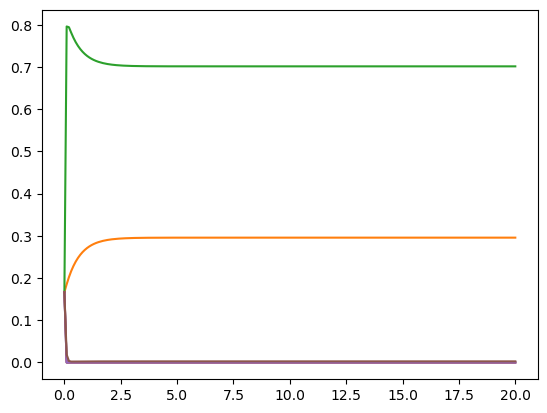

In [115]:
plt.plot(test_soln.ts, jnp.exp(test_soln.ys))

In [714]:
rxn.F_a_idxs

Array([[0, 2]], dtype=int64)

In [715]:
rxn.second_order_edge_prods

Array([[0, 0]], dtype=int64)

In [716]:
rxn.second_order_edge_reactants

Array([[0, 0]], dtype=int64)

In [663]:
rxn.rxn_net_dynamics(1, initial_conditions, (E, B, F, 1,))

Array([ 2.58382895e+03,  9.37059686e-03, -2.60537101e+03,  6.91695404e+00,
        5.14450031e+00,  9.47122680e+00], dtype=float64)

# Analyzing after fix.

In [23]:
n=6
m=int(n*(n-1)/2)
n_second_order=2
suffix=f'task{n_second_order}'
profiles_filename = f'data/turning_points/run_with_100/N{n}_M{m}_S{n_second_order}_profiles_{suffix}.txt'
turning_points_filename = f'data/turning_points/run_with_100/N{n}_M{m}_S{n_second_order}_distributions_{suffix}.txt'

n_profiles=100#10000
n_features=100
n_species=6
    
#turning_points=load_profiles_from_text(profiles_filename, n_profiles, n_features, n_species)
profiles, seeds=load_profiles_from_text(profiles_filename, n_features, n_species)

20001,0.3851947634631461,0.027327788231750232,0.25905949610262413,0.23280008549907924,0.03178697175901286,0.06383179869308146,0.3798436894285801,0.02696462996532862,0.2597453843697584,0.2353581057568744,0.03491744243984156,0.06317161604556212,0.3740146874489235,0.026569029952442876,0.2604925267715534,0.2381445991110681,0.0383275244981633,0.062452463913697666,0.3676758362979705,0.0261388200285307,0.2613050133462773,0.24117482650839162,0.04203589659153864,0.061670402491054266,0.3607955389797106,0.025671853706968804,0.2621868921787667,0.24446389400021873,0.046061048369663675,0.06082153168167843,0.3533432139311355,0.025166053054787137,0.2631420809353841,0.2480264225656393,0.05042087632422273,0.05990207635493167,0.3452901497455996,0.02461946667734762,0.2641742594138638,0.2518761424271758,0.055132185610803505,0.05890849188207035,0.33661052389403184,0.024030338795446214,0.2652867294700659,0.25602539327155266,0.06021008623494987,0.05783758929828524,0.32728264506815347,0.023397193605531066,0.26

In [24]:
print(profiles[0].shape)
print(seeds)

(100, 6)
[20001 20002 20003 20004 20005 20006 20007 20008 20009 20010 20011 20012
 20013 20014 20015 20016 20017 20018 20019 20020 20021 20022 20023 20024
 20025 20026 20027 20028 20029 20030 20031 20032 20033 20034 20035 20036
 20037 20038 20039 20040 20041 20042 20043 20044 20045 20046 20047 20048
 20049 20050 20051 20052 20053 20054 20055 20056 20057 20058 20059 20060
 20061 20062 20063 20064 20065 20066 20067 20068 20069 20070 20071 20072
 20073 20074 20075 20076 20077 20078 20079 20080 20081 20082 20083 20084
 20085 20086 20087 20088 20089 20090 20091 20092 20093 20094 20095 20096
 20097 20098 20099 20100]


In [25]:
tp=[]

for i, profile in enumerate(profiles):
    seed=seeds[i]
    tps, seed=profiles_to_turning_points(seed, turning_points_filename, profile)
    tp.append(tps)
    #seeds.append(seed)

(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1


/Users/serenadebesai/Documents/second_order_rxn_nets/turning_points_inputs.py:48: PeakPropertyWarning: some peaks have a width of 0
  width_peaks, _ = scipy.signal.find_peaks(data, width=min_width)
/Users/serenadebesai/Documents/second_order_rxn_nets/turning_points_inputs.py:49: PeakPropertyWarning: some peaks have a width of 0
  width_troughs, _ = scipy.signal.find_peaks(-data, width=min_width)


In [26]:
print(jnp.array(tp))
bad_idxs=np.argwhere(jnp.array(tp) > 0)[:, 0]
print(bad_idxs)

[[0 0 1 0 0 0]
 [0 0 0 1 1 1]
 [0 0 0 0 0 0]
 [0 0 0 1 1 1]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 0 1 0 1 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 0 1 0 1]
 [0 0 0 0 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 0]
 [1 1 0 0 0 0]
 [0 1 0 0 0 0]
 [1 0 0 1 1 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 1 0 1 0 0]
 [0 0 0 0 0 0]
 [0 1 1 1 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 1 1 1 1]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 1 0 1 

In [5]:
profiles.shape

(500, 100, 6)

20021
[1.00000139 1.00000137 1.00000138 1.00000137 1.00000137 1.00000137
 1.00000137 1.00000136 1.00000135 1.00000135 1.00000135 1.00000135
 1.00000135 1.00000136 1.00000135 1.00000135 1.00000135 1.00000135
 1.00000135 1.00000135 1.00000135 1.00000135 1.00000135 1.00000135
 1.00000135 1.00000135 1.00000135 1.00000135 1.00000135 1.00000135
 1.00000135 1.00000135 1.00000135 1.00000135 1.00000135 1.00000135
 1.00000135 1.00000135 1.00000135 1.00000135 1.00000135 1.00000135
 1.00000135 1.00000135 1.00000135 1.00000135 1.00000135 1.00000135
 1.00000135 1.00000135 1.00000135 1.00000135 1.00000135 1.00000135
 1.00000135 1.00000135 1.00000135 1.00000135 1.00000135 1.00000135
 1.00000135 1.00000135 1.00000135 1.00000135 1.00000135 1.00000135
 1.00000135 1.00000135 1.00000135 1.00000135 1.00000135 1.00000135
 1.00000135 1.00000135 1.00000135 1.00000135 1.00000135 1.00000135
 1.00000135 1.00000135 1.00000135 1.00000135 1.00000135 1.00000136
 1.00000136 1.00000135 1.00000135 1.00000136 1.00000136 

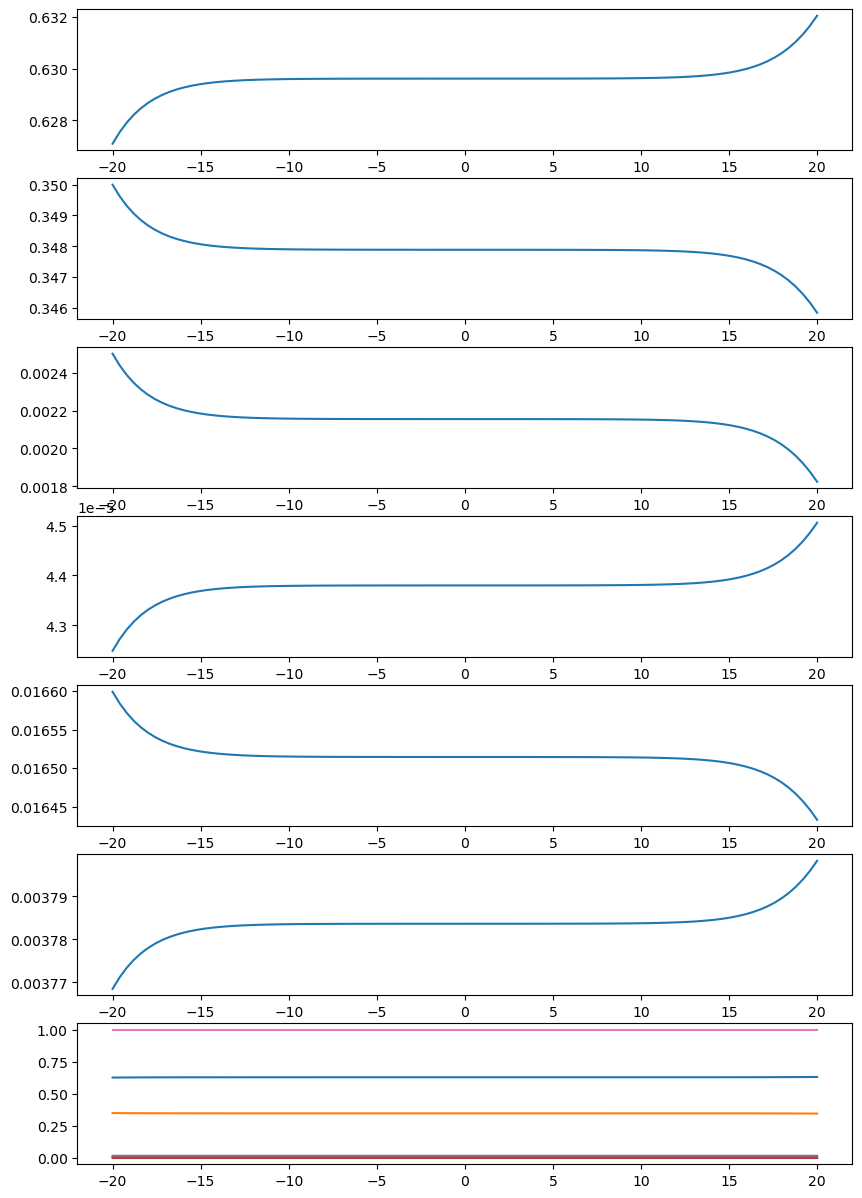

In [27]:
# profile index 
profile_index=20#63
seed=seeds[profile_index]
print(seed)
all_features = jnp.linspace(-20, 20, 100)
fig, axs=plt.subplots(7, figsize=(10, 15))
#plots with no smoothing
for i in range(6):
    axs[i].plot(all_features, profiles[profile_index].T[i])
    axs[6].plot(all_features, profiles[profile_index].T[i])
axs[6].plot(all_features, np.sum(profiles[profile_index], axis=1))
print(np.sum(profiles[profile_index], axis=1))

In [28]:
for s in range(6):
    count=count_turning_points_w_plot(profiles[profile_index].T[s], all_features)
    true_count, ex_prominence_peaks, ex_prominence_troughs, ex_width_peaks, ex_width_troughs=turning_points_inputs.count_turning_points(profiles[profile_index].T[s])
    print('peak info')
    print(true_count)
    print('prominent')
    print(all_features[ex_prominence_peaks], profiles[profile_index].T[s][ex_prominence_peaks])
    print(all_features[ex_prominence_troughs], profiles[profile_index].T[s][ex_prominence_troughs])
    print('wide')
    print('x:', all_features[ex_width_peaks], 'y:', profiles[profile_index].T[s][ex_width_peaks])
    print('x:', all_features[ex_width_troughs], 'y:', profiles[profile_index].T[s][ex_width_troughs])
    print('\n')

NameError: name 'count_turning_points_w_plot' is not defined

In [29]:
#seed=64, n_inputs=1, second_order_edge_idxs=jnp.array([[0, 1]]) (no mass conservation)
#seed=21, n_inputs=2, second_order_edge_idxs=jnp.array([[0,1],[4,1]]) (blow up)
n_inputs=1
rxn=random_rxn_net(n, m, int(seed), n_second_order, n_inputs, second_order_edge_idxs=jnp.array([[0,1],[4,1]]))

In [30]:
#print(rxn.second_order_edges)
print(rxn.second_order_edge_reactants)
print(rxn.second_order_edge_prods)
print(rxn.F_a_idxs)

[[0 2]
 [4 3]]
[[1 3]
 [1 4]]
[[3 2]]


In [31]:
params_file=f'data/turning_points/params_all_N0'#f'data/turning_points/params_all_N3_S0'

f=open(params_file, 'rb')
params_all=pkl.load(f)
f.close()

param=params_all[profile_index % 10000 - 100] #-1 to get 83 for the one that worked
print(profile_index % 10000)

20


In [32]:
F_a=-20
initial_conditions = jnp.log(jnp.array([1/6, 1/6, 1/6, 1/6, 1/6, 1/6]))
all_features = jnp.linspace(-20, 20, 100)
t_points = jnp.linspace(0, 20, 200)
solver = Kvaerno3()
stepsize_controller = PIDController(
        rtol=1e-6,
        atol=1e-9,
        dtmin=1e-11,
        dtmax=1e-1
)
dt = 0.1
E, B, F = param
max_steps = 1000#000
solns=rxn.integrate(solver=solver, stepsize_controller=stepsize_controller, t_points=t_points, dt0=dt, initial_conditions=initial_conditions, args=(E, B, F, F_a,), max_steps=max_steps)

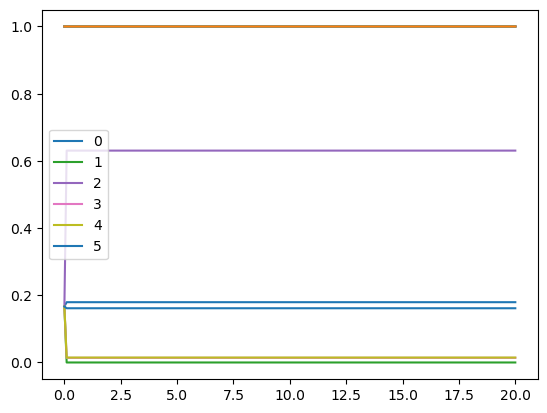

In [33]:
for i in range(6):
    plt.plot(solns.ts, jnp.exp(solns.ys.T[i]), label=f'{i}')
    plt.plot(solns.ts, np.sum(jnp.exp(solns.ys), axis=1))
plt.legend()

In [34]:
test_profile=turning_points.profile(rxn, param, initial_conditions, all_features, solver, stepsize_controller, t_points, dt, max_steps)

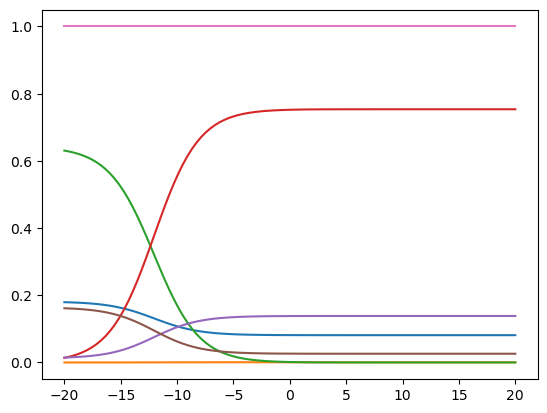

In [35]:
for i in range(6):
    plt.plot(all_features, test_profile.T[i])
plt.plot(all_features, np.sum(test_profile, axis=1))

[] []
[] []
[]
[]
widths
[]
[]
prominences
[]
[]
total finite:  0


np.int64(0)

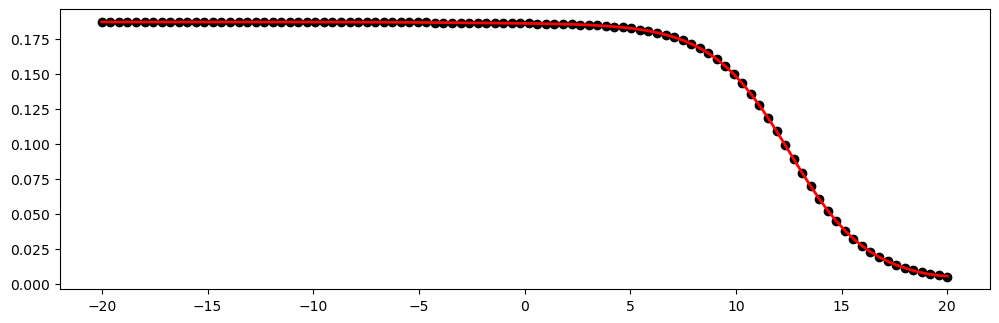

In [806]:
count_turning_points_w_plot(test_profile.T[1], all_features) 

In [ ]:
#for 
#    E, B, F=params
#    solns=[]
#    for F_a in all_features:
#        sol_F_a=rxn.integrate(solver=solver, stepsize_controller=stepsize_controller, t_points=t_points, dt0=dt, initial_conditions=initial_conditions, args=(E, B, F, F_a,), max_steps=max_steps) 
#        solns.append(sol_F_a.ys[-1].copy())
#    return jnp.exp(jnp.array(solns))